# What can we learn about the detector optical properties from studying MIRI fringes?
Similarly to Notebook 2, we want to learn about the optical properties of the resonator that is causing the fringes we see in MRS spectra. Recall that in Notebook 2 the resonator was a Fabry-Pérot etalon which was (safely) approximated as a single element with two plane-parallel mirrors, made out of the same material. Now the resonator under scrutiny is the MIRI short-wavelength detector. Contrary to a Fabry-Pérot etalon, the MIRI detectors are made out of a number of consecutive optical layers, each with their own geometric thickness and optical properties (more about that in Notebook 8). But, as such, it is no longer safe (i.e. justifiable) to model the fringes using a single Fabry-Pérot transmittance function. In this notebook, we do so anyway. The reason is (unjustifiable as it may be) such an analysis can yield zeroth order constraints on the optical properties of the detector (a.k.a. we need to start from somewhere).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source
* MTS 800K BB extended source observed through etalon "ET1A"
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map, the MRS spectral resolution table, and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg           = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
ext_etal_source_sci,ext_etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

# Get spectral resolution table
specres_table = funcs.get_cdps(cdpDir=cdpDir,band=band)[4]

We subtract background exposures where available.

In [3]:
# perform transform
ext_source_bkgsubtr      = ext_source_sci-ext_source_bkg
ext_etal_source_bkgsubtr = ext_etal_source_sci-ext_etal_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows).

In [4]:
ext_source_oddevencorr      = funcs.OddEvenRowSignalCorrection(ext_source_bkgsubtr)
ext_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(ext_etal_source_bkgsubtr)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

We perform the same analysis as in Notebook 2, but rather than carrying out the analysis for etalon data we carry it out for extended source fringes. Although the latter have much smaller contrast compared to the former (i.e. we don't see sharp etalon lines but a blend of etalon lines), the working concepts are exactly the same. So let's try it, let's start by fitting a spectral profile to the fringe peaks to compensate for the sampling effects.

In [5]:
# Pixel trace in MRS slice
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=nslices/2,alpha_pos=0.)

# Extended spectrum fringe peaks
ext_source_peaks = funcs.find_peaks(ext_source_oddevencorr[ypos,xpos], thres=0.3, min_dist=6)
# Fit etalon lines
fitparams,errors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(lambdaMap[ypos,xpos],ext_source_oddevencorr[ypos,xpos],ext_source_peaks,fit_func='gauss1d',sigma0=0.01)
lineheights = funcs.get_amplitude(fitparams=fitparams,fitting_flag=fitting_flag)
linecenters = funcs.get_linecenter(fitparams=fitparams,fitting_flag=fitting_flag)
# Take univariate spline through the fitted peaks of the etalon lines
interpolator = InterpolatedUnivariateSpline(linecenters,lineheights,k=3,ext=3)
ext_source_peakprofile = interpolator(lambdaMap[ypos,xpos])

<IPython.core.display.Javascript object>


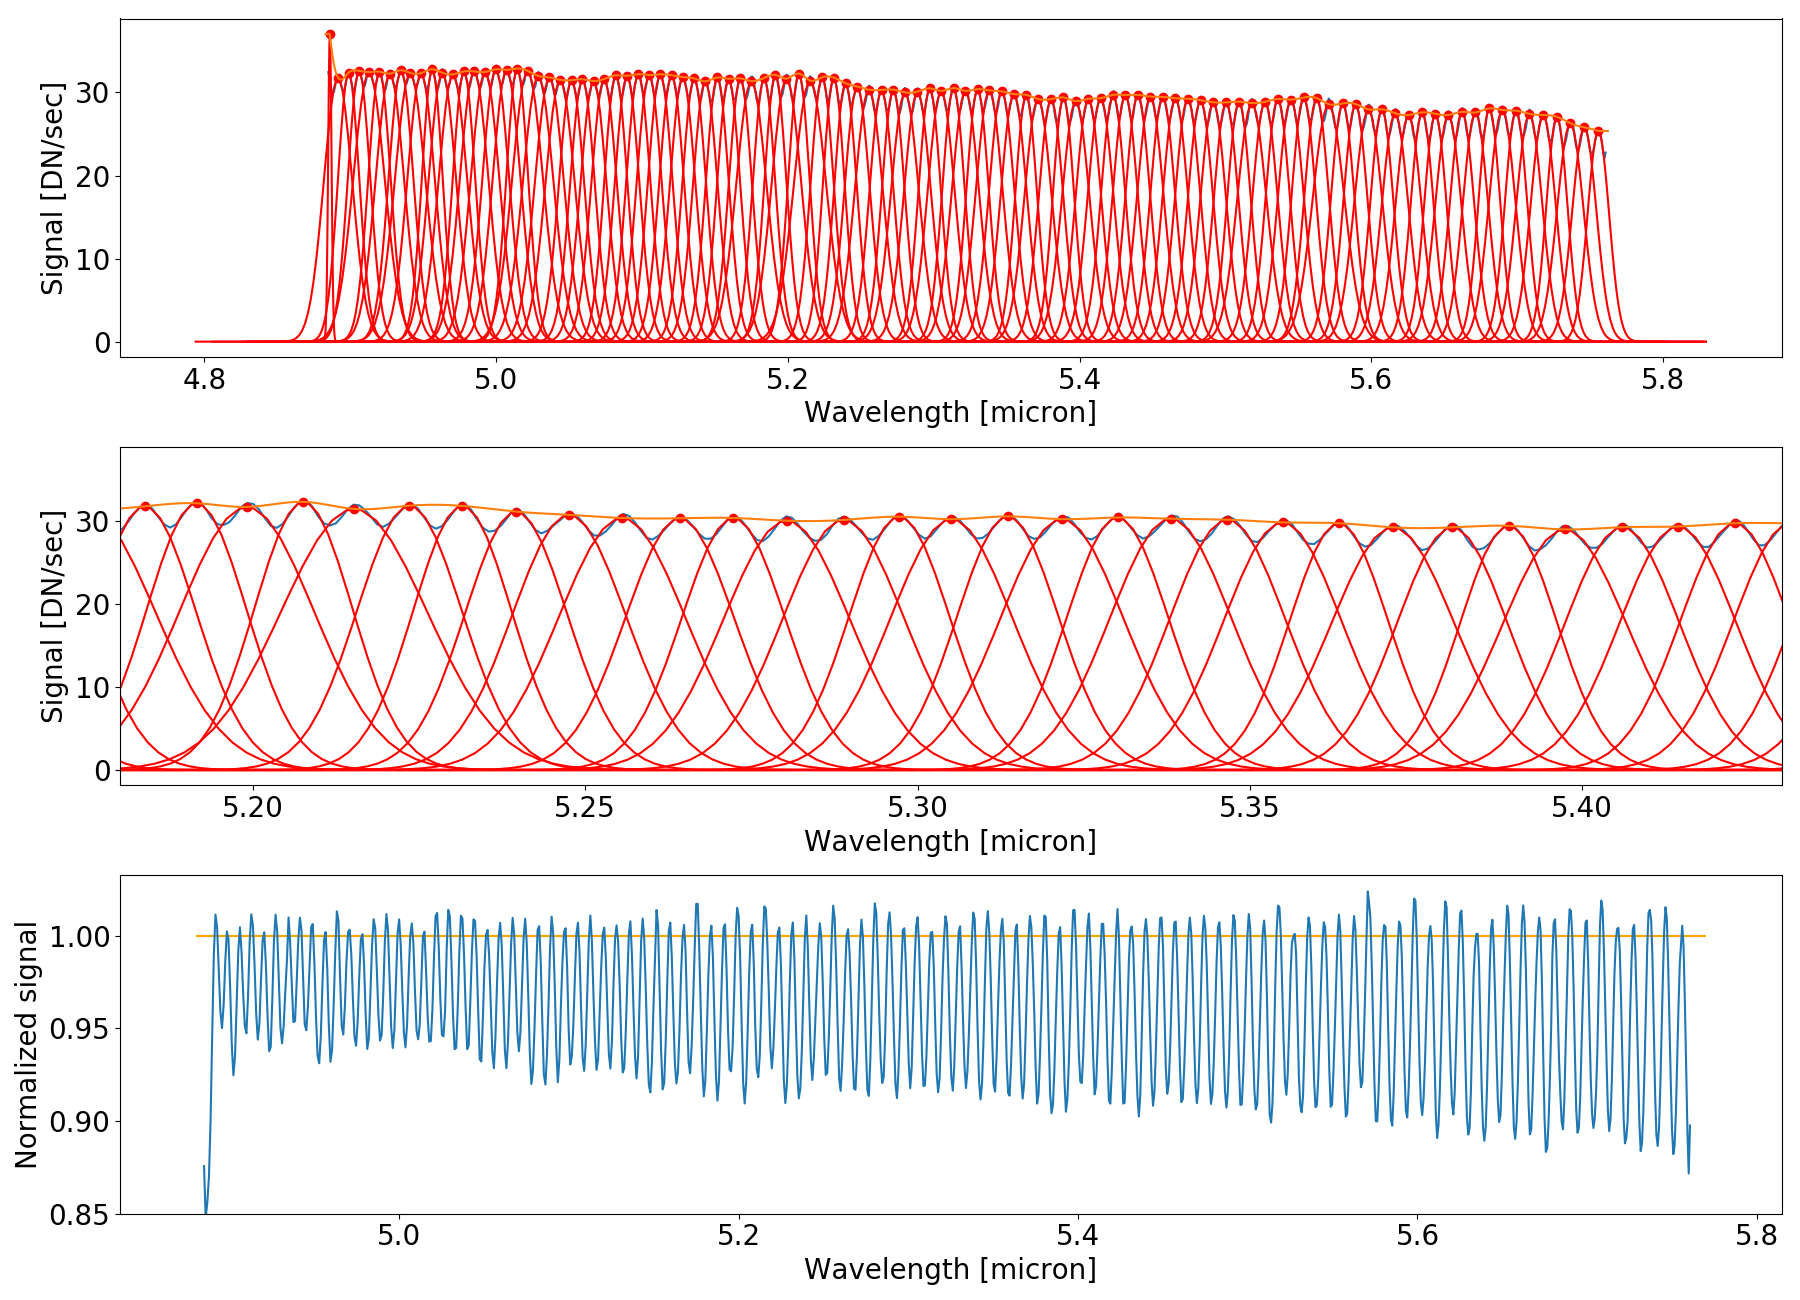

In [6]:
# let's look at the result
fig,axs = plt.subplots(3,1,figsize=(18,13))
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos,xpos],ext_source_oddevencorr[ypos,xpos])
    for i in range(len(fitparams)):
        plotx = np.linspace(fitparams[i][1]-10*fitparams[i][2],fitparams[i][1]+10*fitparams[i][2],100)
        ploty = funcs.gauss1d_woBaseline(plotx,*fitparams[i])
        axs[plot].plot(plotx,ploty,'r')
    axs[plot].plot(linecenters,lineheights,'ro')
    axs[plot].plot(lambdaMap[ypos,xpos],ext_source_peakprofile)
    axs[plot].set_ylabel('Signal [DN/sec]')
axs[2].plot(lambdaMap[ypos,xpos],ext_source_oddevencorr[ypos,xpos]/ext_source_peakprofile)
axs[1].set_xlim(5.18,5.43)
axs[2].hlines(1,4.88,5.77,'orange')
axs[2].set_ylim(0.85)
axs[2].set_ylabel('Normalized signal')
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The lack of data points between fringe peaks and troughs (~4 pixels) results in a bloated Gaussian fit. Clearly this partial resolving of the fringes affects the computed fringe transmission, given the constant underestimation of the fringe peaks.
* The approach that was used to analyze the fringe transmission of etalon data may not be optimal for the study of extended source fringes.  
  
Let's perform the same exercise, but this time use the fringe pixel (/sampled) peak as the nominal fringe peak. This will of course result in sustaining aliasing effects in the final fringe transmission spectrum. However we base our actions on the conclusion that fitting a spectral profile to the fringe peaks does **not** yield better results. Furthermore retaining transmission values larger than 1 is.. awkward.

In [9]:
# Pixel trace in MRS slice
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=nslices/2,alpha_pos=0.)

# Normalize the extended source spectrum to the fringe peak profile
ext_source_norm = funcs.norm_fringe(ext_source_oddevencorr[ypos,xpos], thres=0.3, min_dist=6)

<IPython.core.display.Javascript object>


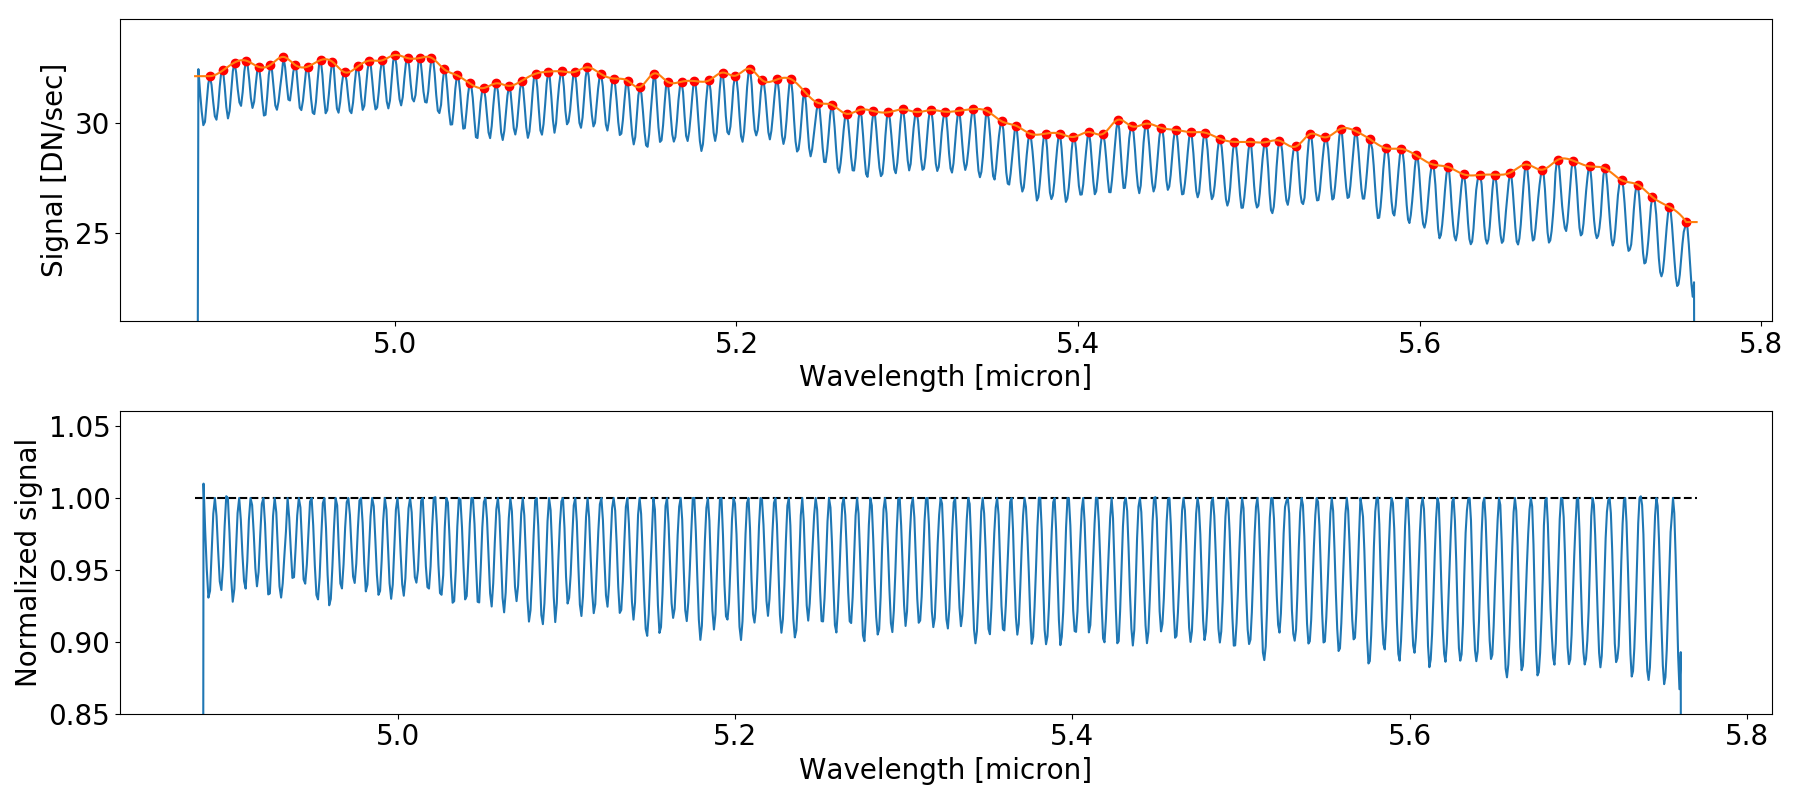

In [10]:
# let's look at the result
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambdaMap[ypos,xpos],ext_source_norm[0])
axs[0].plot(lambdaMap[ypos,xpos][ext_source_norm[1]],ext_source_norm[0][ext_source_norm[1]],'ro')
axs[0].plot(lambdaMap[ypos,xpos],ext_source_norm[2])
axs[1].plot(lambdaMap[ypos,xpos],ext_source_norm[0]/ext_source_norm[2])
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
axs[0].set_ylim(21)
axs[1].set_ylim(0.85)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* Aliasing effects manifest in the erratic depth of the normalized signal (fringe) minima. This is because we don't probe the "true" fringe maximum in the source spectrum, but a fringe transmission value slightly lower or higher than the nominal one.
* Interestingly, similar to the etalon data studied in Notebook 2, there appears to be a second frequency overlayed on the source spectrum, namely a low frequency fringe.
* Due to the way the fringe transmission is extracted from the spectrum, the low-transmission frequency is erased in the final transmission profile. The inclusion of this low-frequency fringe in the final transmission profile seems to be even trickier (/noisier) than that performed in Notebook 2 - Test 3. We will come back to this.  
  
Let's carry on, as per Notebook 2, with Test 1.

### Test 1: Determining detector optical properties from the data (optical thickness)
Information about the optical properties of the detector can be attained by studying the fringes in wavenumber space. [Recall:] Assuming that the detector layers are plane-parallel, and that the incidence angle is small, subsequent peaks in transmission occur at a constant distance from one another. This distance relates to the optical thickness of the resonating layer.

In [11]:
fringepeaks_wavelength     = lambdaMap[ypos,xpos][ext_source_norm[1]]       # microns
fringepeaks_wavenumber     = np.flipud(10000./fringepeaks_wavelength)       # cm-1
mean_fringepeak_separation = np.mean(np.diff(fringepeaks_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_fringepeak_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_fringepeak_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 2.92 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1712.34 um


<IPython.core.display.Javascript object>


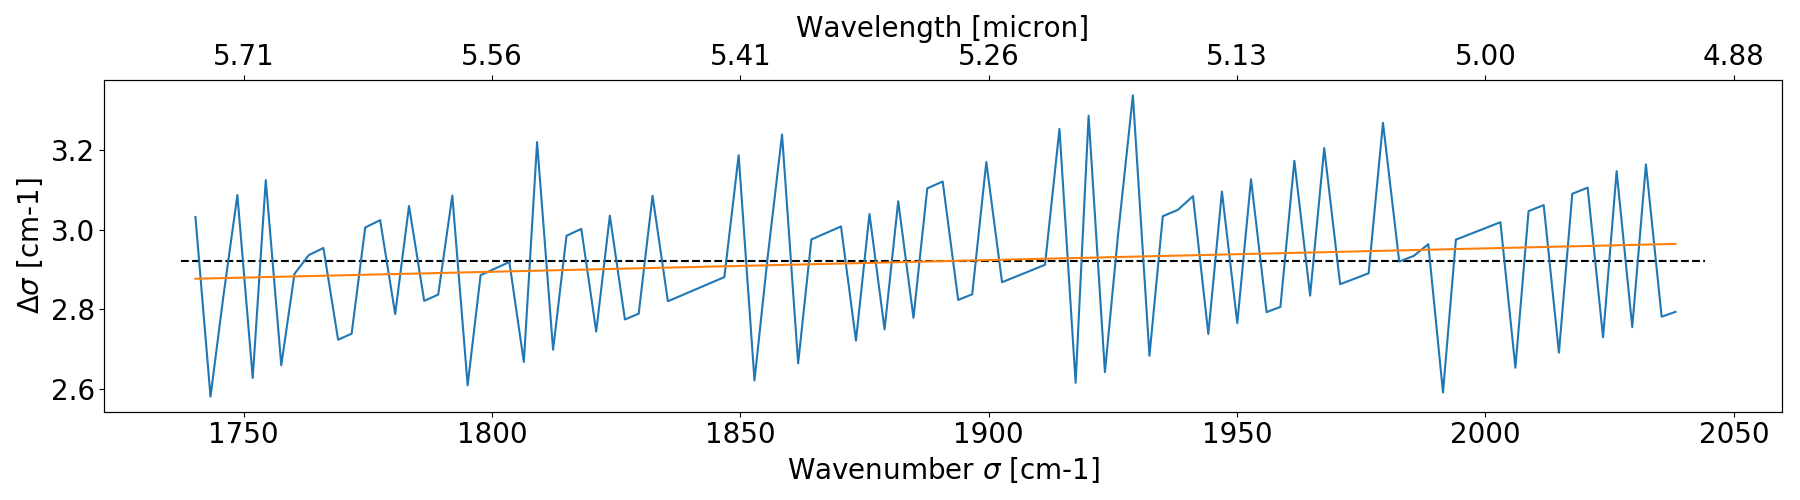

In [13]:
# Let's look at the results
fig = plt.figure(figsize=(18,5))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])
axs1.plot(fringepeaks_wavenumber[1:-2],funcs.straight_line(fringepeaks_wavenumber[1:-2],*popt))
axs1.hlines(mean_fringepeak_separation,fringepeaks_wavenumber[0],fringepeaks_wavenumber[-1],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The MRS data of the MTS 800K BB extended source, using the available wavelength calibration, tell us that the optical thickness of the detector is approximately 1710um. We expect this to be related to the geometric thickness of the full detector, from the anti-reflection coating down to the aluminium pads surrounding the pixels. This is based on the assumption that the fill factor of the aluminium pad w.r.t. the oxide ("pixel surface") is high (Martyn Wells, private communication).
* We know that the detector layers are made out of doped and un-doped silicon. The index of refraction of silicon at 5um is ~3.39. As such this would entail a geometric distance through the detector, from the anti-reflection coating to the aluminium pads, of 1712um/3.39 = 505um.
* We see that performing a linear regression yields a non-zero slope to the fringe peak separation data. In this case the sampling effects are present in the data. The linear regression is most certainly affected by this fact.

### Test 1: Determining detector properties from the data (intensity reflectivity)
Before, for the etalon data, we assumed that the etalon's reflecting mirrors were made out of the same material, and thus a single (wavelength-dependent) intensity reflectivity could be determined for the optical element. Although we know this to not be true for the detector (zinc-sulfide for the anti-reflection coating and aluminium for the pixels), we can still determine an "effective" reflectivity from the measurements. This can simply be done by looking at the fringe transmission trough level and relating that to the etalon finesse value, thus reflectivity.

In [14]:
# at lower wavelength end
T_e1 = 0.933
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e1)
print 'At the lower wavelength end we have:'
print ' Finesse = {} \n R_solution1 = {} \n R_solution2 = {} (physically valid solution)\n'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_low = R_solution2

# at higher wavelength end
T_e2 = 0.882
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e2)
print 'At the higher wavelength end we have:'
print ' Finesse = {} \n R_solution1 = {} \n R_solution2 = {} (physically valid solution)'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_high = R_solution2

At the lower wavelength end we have:
 Finesse = 0.0718113612004 
 R_solution1 = 57.68 
 R_solution2 = 0.02 (physically valid solution)

At the higher wavelength end we have:
 Finesse = 0.133786848073 
 R_solution1 = 31.87 
 R_solution2 = 0.03 (physically valid solution)


<IPython.core.display.Javascript object>


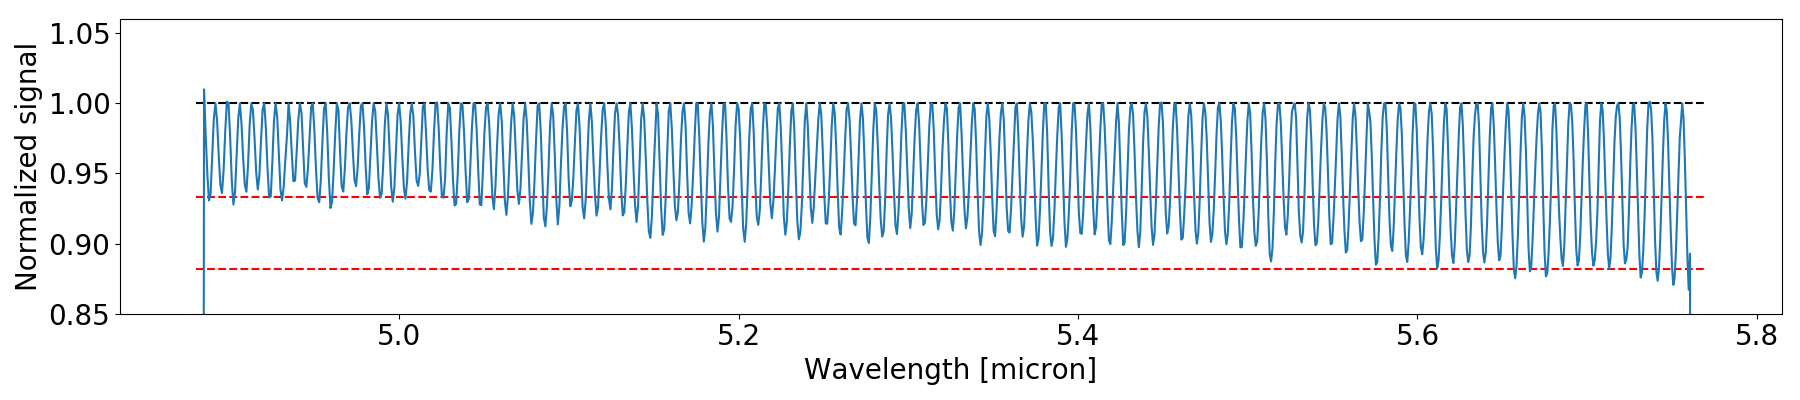

In [16]:
plt.figure(figsize=(18,4))
plt.plot(lambdaMap[ypos,xpos],ext_source_norm[0]/ext_source_norm[2])
plt.hlines(1,4.88,5.77,linestyle='dashed')
plt.hlines([T_e1,T_e2],4.88,5.77,'r',linestyle='dashed')
plt.ylim(0.85)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.tight_layout()

### Test 2: Modeling the detector interference with a transmittance function
We use the information derived from the extended source data to model the transmittance function of the detector. It is important to note which dataset the modeling is based on. We know that the fringe transmission differs with different optical stimuli and their spatial properties! The real optical properties of the detector should not change however.

In [17]:
wavelengths = np.linspace(4.88,5.77,10000)         # um
wavenumbers = np.flipud(10000./wavelengths)        # cm-1

R   = np.flipud(np.linspace(R_low,R_high,10000))   # [-]
D   = 1./(2*mean_fringepeak_separation)            # cm
phi = np.pi                                        # rad

T_e = funcs.FPfunc(wavenumbers,R,D,phi)            # [-]

<IPython.core.display.Javascript object>


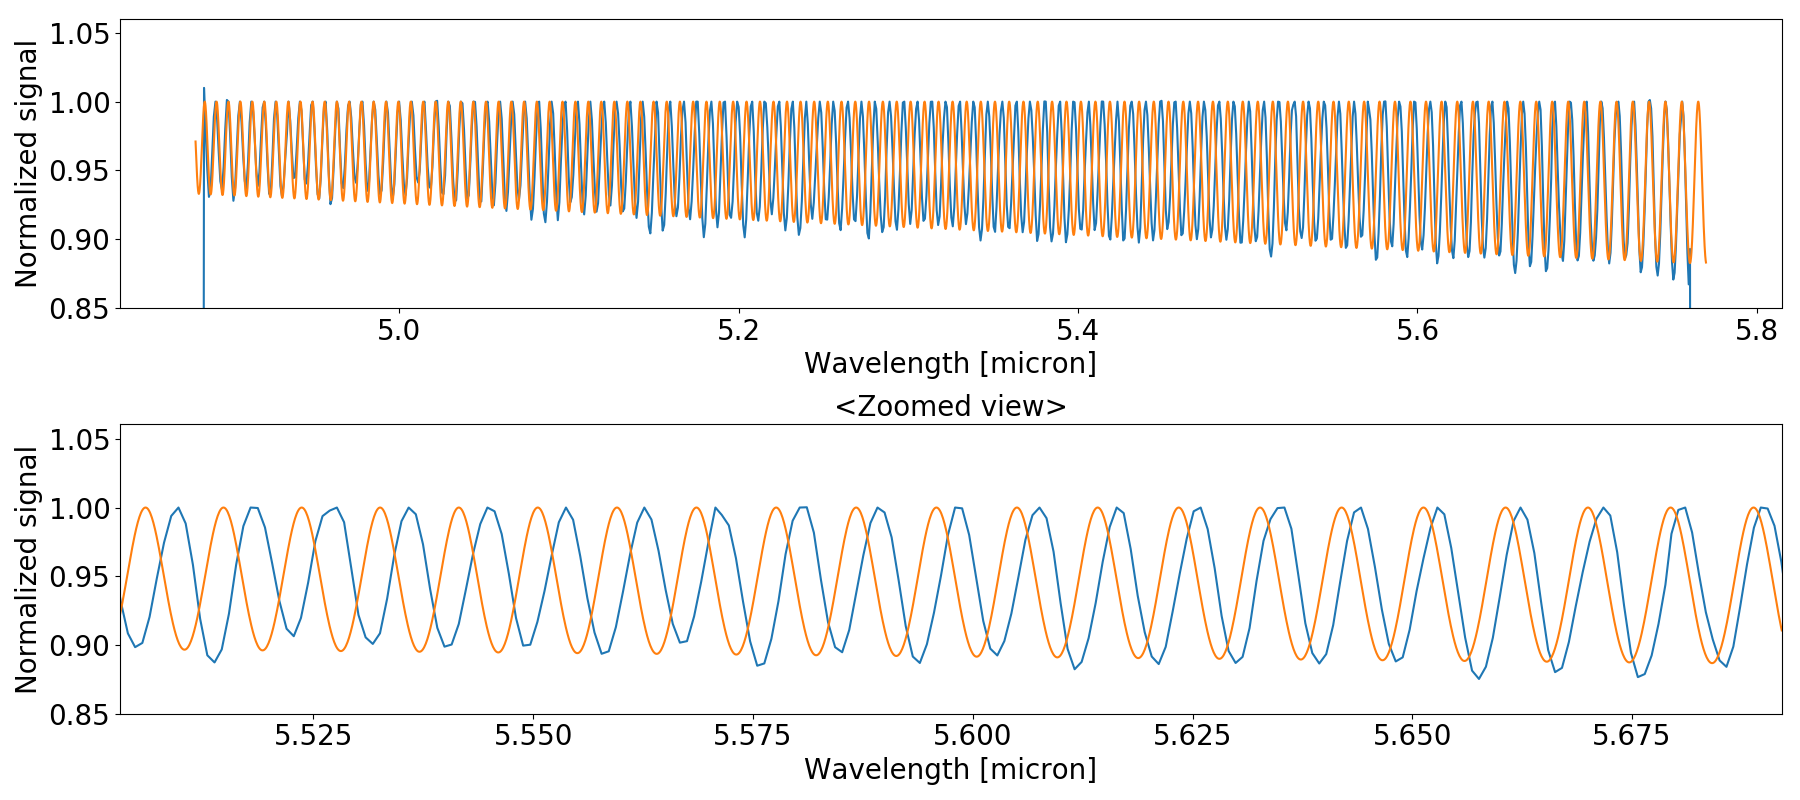

In [18]:
# Let's look at the result
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos,xpos],ext_source_norm[0]/ext_source_norm[2])
    axs[plot].plot(wavelengths,np.flipud(T_e))
    axs[plot].set_ylim(0.85)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
axs[1].set_xlim(5.503,5.692)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* As we have seen in Notebook 1, although the wavelength calibration may be sound (cross-checked with the extended etalon data), the frequency of the fringes may change independently of wavelength. This can be due to:
    * changes in optical thickness; note however that the refractive index of silicon does not change appreciably over the wavelength range of MRS band 1A, thus this implies a change in geometric thickness
    * a non-zero (normal) incidence angle; recall from Notebook 2 that a cos(theta) term comes into play in the Fabry-Pérot transmittance function. Theta is the incidence angle with respect to the normal outward vector of the detector.

### Test 3: How do the optical properties derived from an extended source measurement compare with those derived from a point source measurement?
Let's carry out the above analysis for the point source fringes. Recall from Notebook 4 - Test 1 that to get the point source fringe transmission we first build a spectral grid and then determine the centroid of the source in a slice in each spectral grid bin. The fringe transmission is probed by the signal at the fitted source centroid.

In [19]:
# Construct the spectral grid
lambcens,lambfwhms = funcs.spectral_gridding(band,d2cMaps,specres_table=specres_table)

In [ ]:
# Determine point source centroid
point_source_p1_centroid = funcs.point_source_centroiding(point_source_p1_oddevencorr,band,d2cMaps,spec_grid=[lambcens,lambfwhms],fit='1D')

In [21]:
# Normalize the source signal
point_source_p1_norm = funcs.norm_fringe(point_source_p1_centroid[0],thres=0,min_dist=2,k=3,ext=3)

<IPython.core.display.Javascript object>


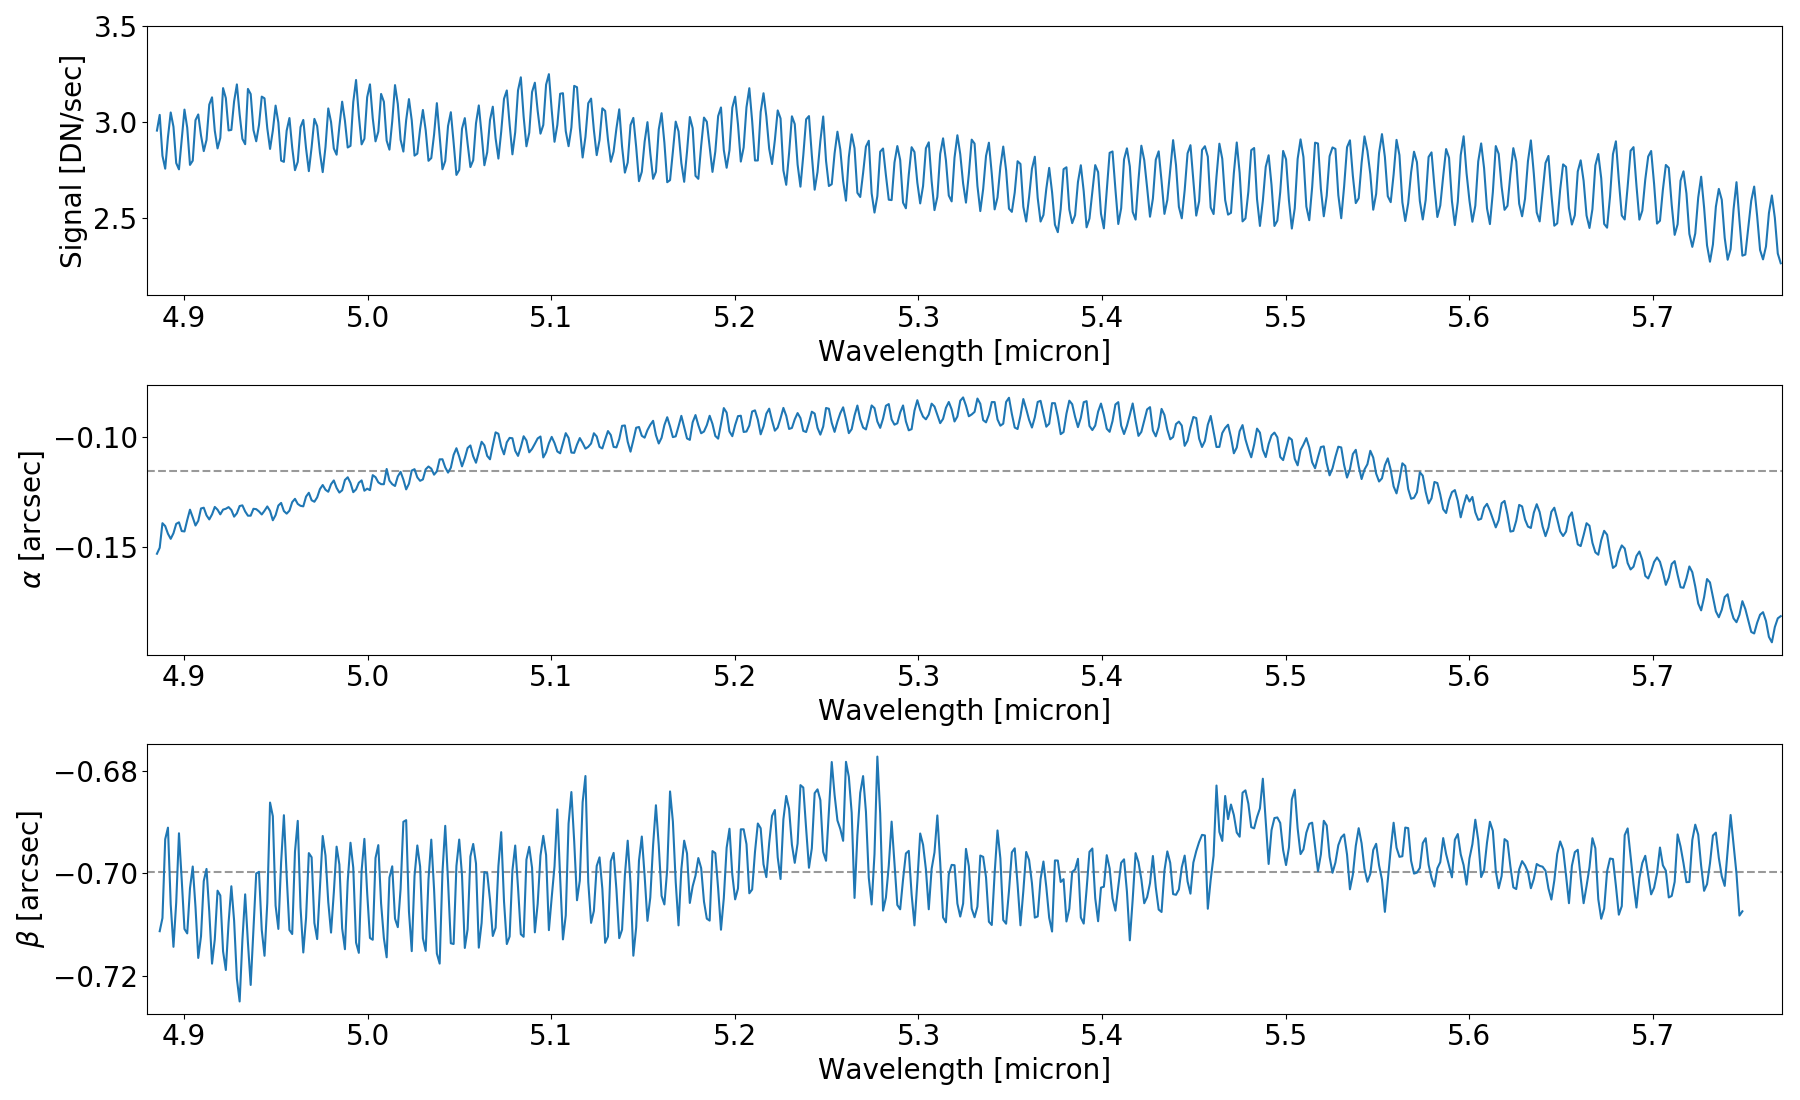

<IPython.core.display.Javascript object>


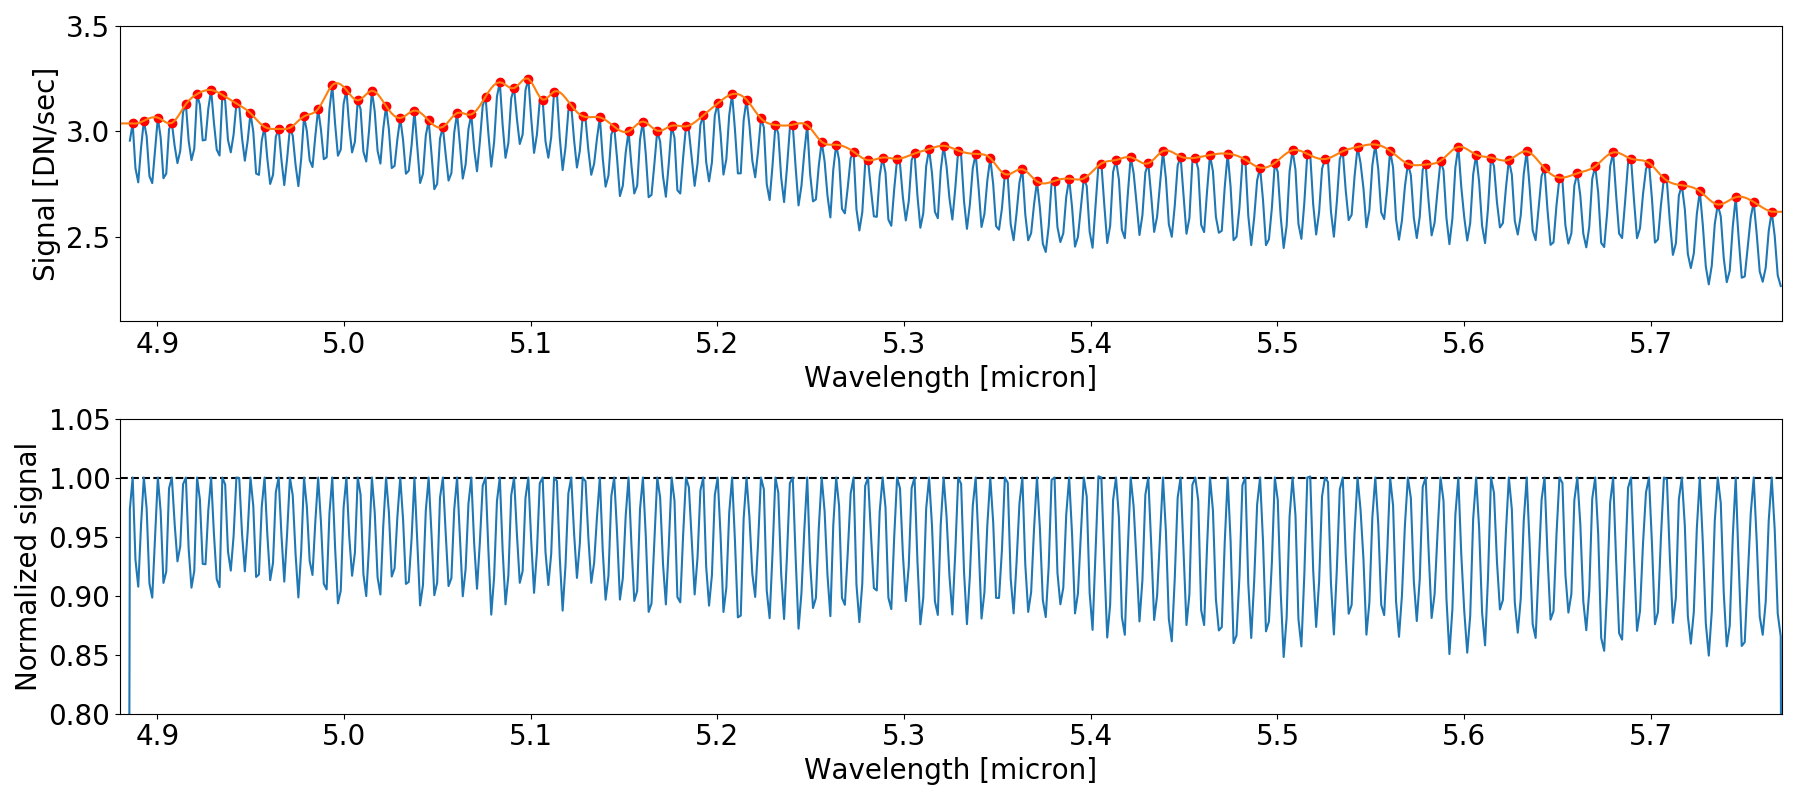

In [22]:
# make first plots
fig,axs = plt.subplots(3,1,figsize=(18,11))
axs[0].plot(lambcens,point_source_p1_centroid[0])
axs[1].plot(lambcens,point_source_p1_centroid[1])
axs[1].hlines(np.mean(point_source_p1_centroid[1][~np.isnan(point_source_p1_centroid[1])]),4.88,5.77,alpha=0.4,linestyle='dashed')
axs[2].plot(lambcens,point_source_p1_centroid[2])
axs[2].hlines(np.mean(point_source_p1_centroid[2][~np.isnan(point_source_p1_centroid[2])]),4.88,5.77,alpha=0.4,linestyle='dashed')
axs[0].set_ylim(2.1,3.5)
axs[0].set_ylabel(r'Signal [DN/sec]')
axs[1].set_ylabel(r'$\alpha$ [arcsec]')
axs[2].set_ylabel(r'$\beta$ [arcsec]')
for plot in range(3):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].plot(lambcens,point_source_p1_centroid[0])
axs[0].plot(lambcens[point_source_p1_norm[1]],point_source_p1_centroid[0][point_source_p1_norm[1]],'ro')
axs[0].plot(lambcens,point_source_p1_norm[2])
axs[1].plot(lambcens,point_source_p1_norm[0]/point_source_p1_norm[2])
axs[1].hlines(1,4.88,5.77,linestyle='dashed')
axs[0].set_ylim(2.1,3.5)
axs[1].set_ylim(0.8,1.05)
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_xlabel('Wavelength [micron]')
plt.tight_layout()

In [23]:
# Determine optical properties of the resonator
fringepeaks_wavelength     = lambcens[point_source_p1_norm[1]]       # microns
fringepeaks_wavenumber     = np.flipud(10000./fringepeaks_wavelength)       # cm-1
mean_fringepeak_separation = np.mean(np.diff(fringepeaks_wavenumber)[1:-1]) # omit first and last data point
# fit straight line through distance data for comparison
popt,pcov = curve_fit(funcs.straight_line,fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])

print r'Mean etalon line separation in wavenumber space is: Δσ = {} cm-1'.format(round(mean_fringepeak_separation,2) )
print r'The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = {} um'.format(round(10000./(2*mean_fringepeak_separation),2) )

Mean etalon line separation in wavenumber space is: Δσ = 2.92 cm-1
The optical thickness D of the etalon is related to Δσ as: D = 1/(2Δσ) = 1714.26 um


<IPython.core.display.Javascript object>


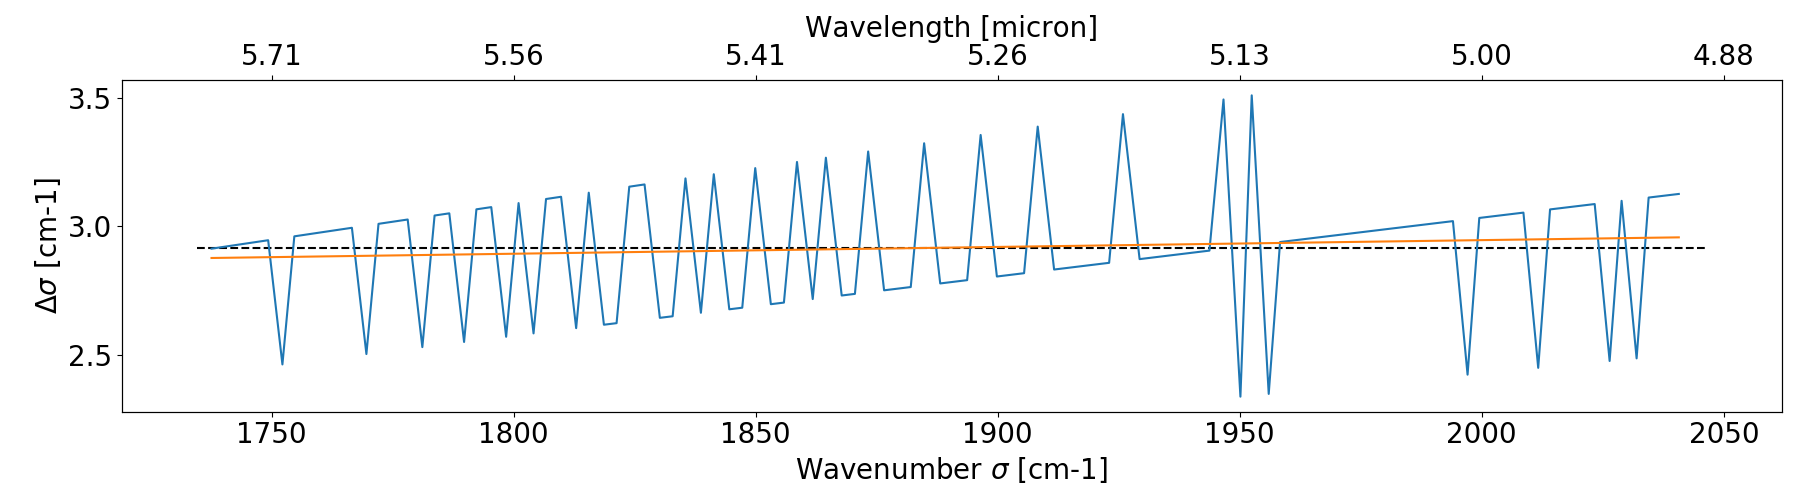

In [24]:
# Let's look at the results
fig = plt.figure(figsize=(18,5))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(fringepeaks_wavenumber[1:-2],np.diff(fringepeaks_wavenumber)[1:-1])
axs1.plot(fringepeaks_wavenumber[1:-2],funcs.straight_line(fringepeaks_wavenumber[1:-2],*popt))
axs1.hlines(mean_fringepeak_separation,fringepeaks_wavenumber[0],fringepeaks_wavenumber[-1],linestyle='dashed')
axs1.set_xlabel(r'Wavenumber $\sigma$ [cm-1]')
axs1.set_ylabel(r'$\Delta \sigma$ [cm-1]')
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([1750.,1800.,1850.,1900.,1950.,2000.,2050.])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(funcs.tick_function(tickmarks))
axs2.set_xlabel('Wavelength [micron]')
plt.tight_layout()

### Remarks:
* The optical thickness determined for the detector from the point source data matches that of the extended source data, given the sampled nature/uncertainties of the analysis.
  
What about the intensity reflectivity of the point source fringes?

In [19]:
# at lower wavelength end
T_e1 = 0.914
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e1)
print 'At the lower wavelength end we have:'
print ' Finesse = {} \n R_solution1 = {} \n R_solution2 = {} (physically valid solution)\n'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_low = R_solution2

# at higher wavelength end
T_e2 = 0.86
F,R_solution1,R_solution2 = funcs.reflectivity_from_continuum(T_e2)
print 'At the higher wavelength end we have:'
print ' Finesse = {} \n R_solution1 = {} \n R_solution2 = {} (physically valid solution)'.format(F,round(R_solution1,2),round(R_solution2,2) )
R_high = R_solution2

At the lower wavelength end we have:
 Finesse = 0.0940919037199 
 R_solution1 = 44.49 
 R_solution2 = 0.02 (physically valid solution)

At the higher wavelength end we have:
 Finesse = 0.162790697674 
 R_solution1 = 26.53 
 R_solution2 = 0.04 (physically valid solution)


### Remarks:
* Reflectivity values are similar to the extended source derived values.

In [22]:
# make etalon model
wavelengths = np.linspace(4.88,5.77,10000)         # um
wavenumbers = np.flipud(10000./wavelengths)        # cm-1

R   = np.flipud(np.linspace(R_low,R_high,10000))   # [-]
D   = 1./(2*mean_fringepeak_separation)            # cm
phi = np.pi+0.8                                     # rad

T_e = funcs.FPfunc(wavenumbers,R,D,phi)            # [-]

<IPython.core.display.Javascript object>


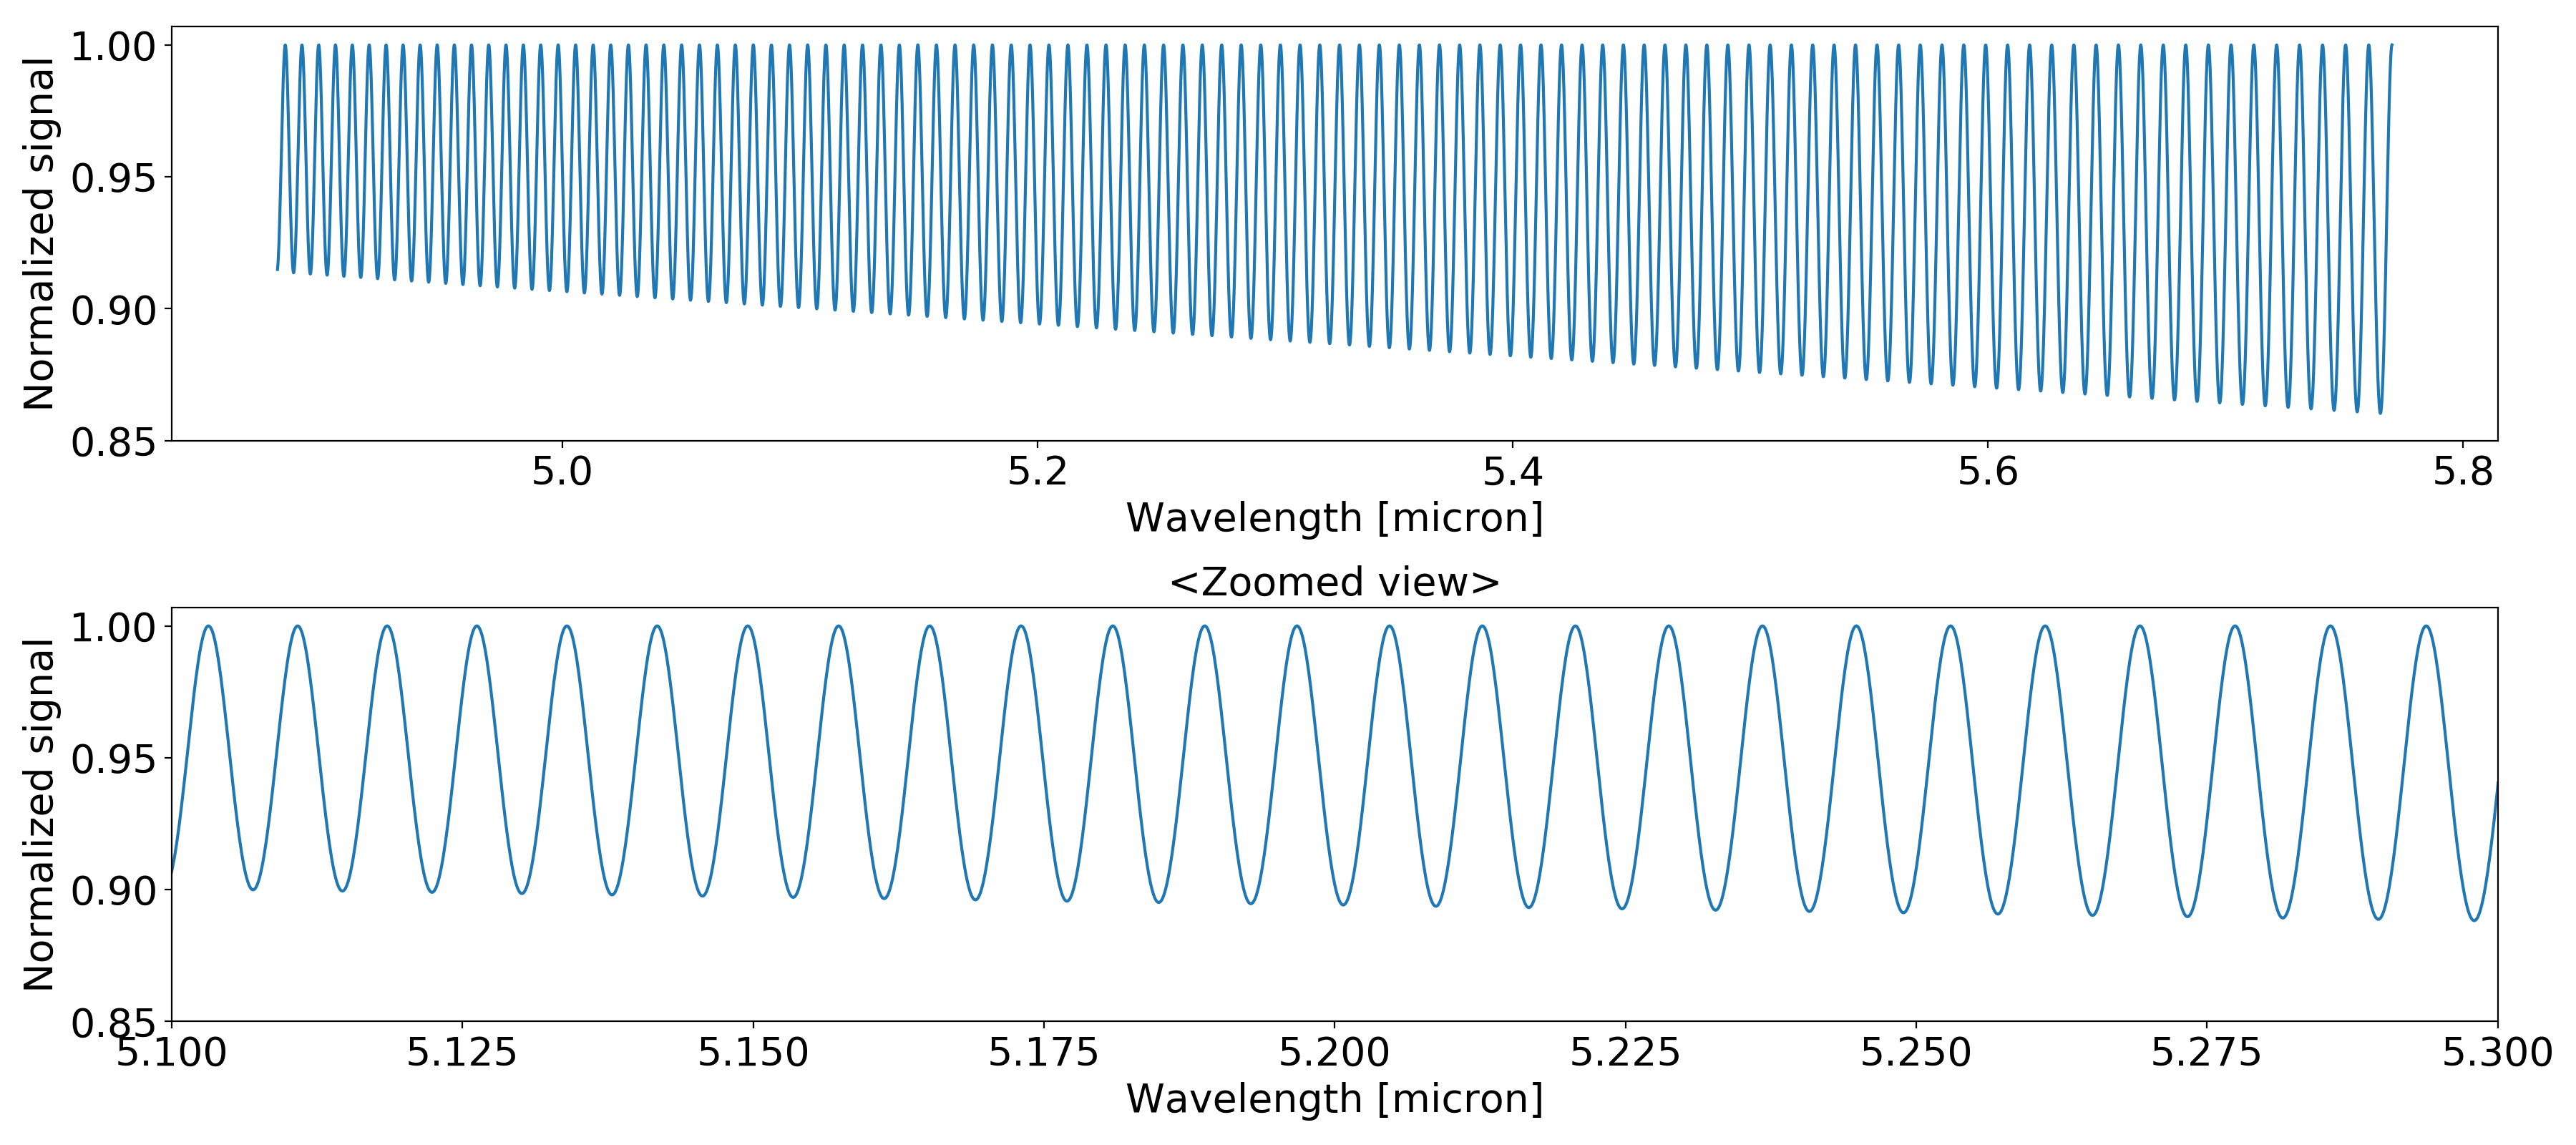

In [23]:
# Let's look at the result
fig,axs = plt.subplots(2,1,figsize=(18,8))
for plot in range(2):
    axs[plot].plot(lambcens,point_source_p1_norm[0]/point_source_p1_norm[2])
    axs[plot].plot(wavelengths,np.flipud(T_e))
    axs[plot].set_ylim(0.85)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Normalized signal')
axs[1].set_xlim(5.1,5.3)
axs[1].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* Much like the extended source data, there seems to be a frequency (optical thickness) variation over the wavelength range covered (i.e. over the length of the detector). This was not the point of this test. We know that the wavelength calibration is consistent, thus it is the optical parameters that should be examined in more detail. But how can we do that?
  
For the sake of completeness let's overplot the point source fringes and the extended source fringes.

<IPython.core.display.Javascript object>


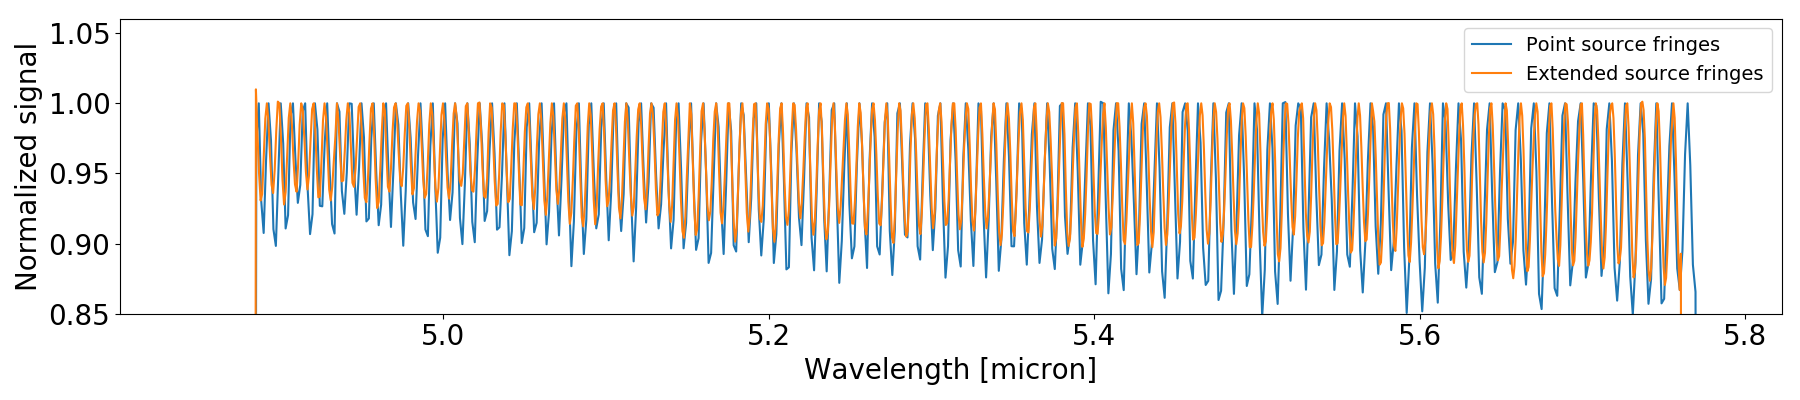

In [29]:
plt.figure(figsize=(18,4))
plt.plot(lambcens,point_source_p1_norm[0]/point_source_p1_norm[2],label='Point source fringes')
plt.plot(lambdaMap[ypos,xpos],ext_source_norm[0]/ext_source_norm[2],label='Extended source fringes')
plt.ylim(0.85)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()

### Remarks:
* It can be agreed upon (from the analyses carried out thus far) that the discrepancy between point source and extended source fringes is by all means small (below a fringe period difference). However this behavior is erratic, and if not analyzed very meticulously, it can introduce large amounts of correlated noise instead of fixing a real problem.

## Conclusions:  
* Given the low contrast of the MIRI fringes, fitting a spectral (Gaussian) profile to the fringe peaks is found to give sub-par results. For that reason we use the discrete ("pixel") peaks of the fringes to determine the fringe transmission.
* The optical thickness calculated from the extended source fringes is 1712um.
* The optical thickness calculated from the point source fringes is 1714um.
* Given the discrete nature of the analysis, the optical thicknesses measured from the extended and point source are found to be consistent.
* The intensity reflectivity of the point and extended source is of the same order, but again, the devil is in the details.
  
## Follow-up question:  
Can we find a way to "scan" the optical properties of the detector from the lower wavelengths (one side of the detector) to the higher wavelengths (opposite side of the detector) such as to study the local properties of the detector?